# The Battle of Neighborhoods
## Week 5 assignment (week 2 of the final assignment)

## < Introduction >

San Francisco and Los Angeles are populous and multi-cultural cities in California. By looking into the categories of the stores and where they are located, we can visualize the similarity between the two cities. 

In this project, I will explore similarity between San Francisco and Los Angeles based on the categories of the restaurants and the location.

## < Business Problem>

The aim of this anlaysis to help tourists or people who would like to start their restaurants and consider which location is better. 

## < Data and Results>
- Based on the list of neighborhoods in San Francisco (SF) and Los Angeles (LA), I pulled the list of venues from Foursquare. 
- To look at the categories of the restaurants, I limited the venue categories to the ones that include 'Restaurants' in the names. 

- To understand the cultural diversity in the cities, I used K-Means with the number of clusters, 5. 
- For visualization, I used folium maps and bar graphs.
- Later in the analysis, I used statistics to compare the two cities.

Import Libraries

In [71]:
import pandas as pd
import numpy as np
import folium
import requests
import seaborn as sns

# !pip install geopy
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans

Foursquare credentials

In [2]:
CLIENT_ID = 'OHRQ4AIDL5RU4SANERINI5MQ4GP1YQRYUVJKTE3ZCKHRTVER' # your Foursquare ID
CLIENT_SECRET = '2EPGFYHO1SWGU2OXHXQWHLBU0VZDCXEH0T3VOF2JQGV4OQFT' # your Foursquare Secret
ACCESS_TOKEN = 'ZTKXSBLOWL40U4DGK4OKLQX0N0ZNXRV200F12NPPWR2LGZT3' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OHRQ4AIDL5RU4SANERINI5MQ4GP1YQRYUVJKTE3ZCKHRTVER
CLIENT_SECRET:2EPGFYHO1SWGU2OXHXQWHLBU0VZDCXEH0T3VOF2JQGV4OQFT


### Let's begin with San Francisco.
## San Francisco

Find the latitude/longitude of San Francisco as a reference

In [3]:
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

37.7790262 -122.419906


Define a function 'latlng' to find the latitudes and longitudes for each neighborhoods in the list, neigh_SF. These latitudes and longitudes are used to find the venues in Foursquare.

In [177]:
def latlng(neighborhood):
    address = neighborhood+', SF'
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    return [latitude, longitude]

In [161]:
neigh_SF = ['Seacliff','Haight Ashbury','Outer Mission','Inner Sunset','Downtown/Civic Center','Diamond Heights',
'Lakeshore','Russian Hill','Noe Valley','Treasure Island','Outer Richmond','Crocker Amazon',
'Excelsior','Parkside','Financial District','Ocean View','Mission',
'Inner Richmond','Visitacion Valley','Pacific Heights','Presidio Heights','Glen Park',
'Potrero Hill','Castro','Twin Peaks','Bernal Heights','Presidio',
'Nob Hill','Chinatown','Outer Sunset','Western Addition','Golden Gate Park']

# SF_data includes the name of the neighborhoods and their latitude/longitude.

SF_data = pd.DataFrame(columns=['Neighborhood', 'Latitude', 'Longitude'])

for i in range(0, len(neigh_SF)):
    SF_data=SF_data.append({'Neighborhood':neigh_SF[i], 'Latitude':latlng(neigh_SF[i])[0], 'Longitude':latlng(neigh_SF[i])[1]},
                           ignore_index=True)
    

Let's find the venues within 500m from the location, up to 100 venues. 
'getNearbyVenues' is to make it easier to pull the data from Foursquare for each neighborhood.

In [6]:
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [162]:
SF_venues = getNearbyVenues(names=SF_data['Neighborhood'], latitudes=SF_data['Latitude'], longitudes=SF_data['Longitude'])
SF_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Seacliff,37.788541,-122.486916,Seacliff,37.788259,-122.486401,Neighborhood
1,Seacliff,37.788541,-122.486916,China Beach,37.788090,-122.491186,Beach
2,Seacliff,37.788541,-122.486916,Rochambeau Playground,37.784892,-122.484309,Playground
3,Haight Ashbury,37.770028,-122.446983,Haight Street Market,37.770005,-122.447634,Supermarket
4,Haight Ashbury,37.770028,-122.446983,Nice Kicks,37.770365,-122.445885,Shoe Store
...,...,...,...,...,...,...,...
1378,Golden Gate Park,37.769368,-122.482184,Park Presidio Bypass & Crossover Drive,37.771129,-122.479429,Intersection
1379,Golden Gate Park,37.769368,-122.482184,Alice's Summerthing,37.769527,-122.486229,Music Venue
1380,Golden Gate Park,37.769368,-122.482184,Dirtybird BBQ,37.767384,-122.485446,BBQ Joint
1381,Golden Gate Park,37.769368,-122.482184,MUNI Bus Stop - Fulton & 25th,37.772572,-122.483979,Bus Stop


We limit the search to venues that contain 'Restaurant'

In [9]:
SF_food = SF_venues[SF_venues['Venue Category'].str.contains('Restaurant')]
SF_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,Haight Ashbury,37.770028,-122.446983,Om Indian Cuisine,37.769687,-122.449678,Indian Restaurant
16,Haight Ashbury,37.770028,-122.446983,DragonEats,37.769432,-122.450097,Vietnamese Restaurant
17,Haight Ashbury,37.770028,-122.446983,VeganBurg,37.770156,-122.446522,Vegetarian / Vegan Restaurant
45,Haight Ashbury,37.770028,-122.446983,Parada 22,37.769291,-122.452111,Caribbean Restaurant
52,Haight Ashbury,37.770028,-122.446983,Cha Cha Cha,37.769271,-122.452006,Tapas Restaurant


### Data Visualization using folium map

In [10]:
def venues_pin(venues_map, dataframe, color):
    for lat, lng, label in zip(dataframe['Neighborhood Latitude'], dataframe['Neighborhood Longitude'], dataframe['Venue Category']):
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            color=color,
            popup=label,
            fill = True,
            fill_color=color,
            fill_opacity=0.2
        ).add_to(venues_map)
    
    return venues_map

In [11]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='San Francisco',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

venues_pin(venues_map, SF_food, 'purple')

This map shows the location of the restaurants in SF area, indicated by purple dots, but it misses many restaurants. This maybe because some restaurants are too close to each other. To fix this, I used 'marker cluster' instead. When you click the numbers, you can see more restaurants nearby.

In [12]:
venues_map2 = folium.Map(location=[latitude, longitude], zoom_start=12)

marker_cluster = MarkerCluster().add_to(venues_map2)

for lat, lng, label in zip(SF_food['Neighborhood Latitude'], SF_food['Neighborhood Longitude'], SF_food['Venue Category']):
    folium.CircleMarker(
            [lat, lng],
            radius=2,
            color='purple',
            popup=label,
            fill = True,
            fill_color='purple',
            fill_opacity=0.2
        ).add_to(marker_cluster)
    
venues_map2

In [13]:
SF_food['Venue Category'].unique()

array(['Indian Restaurant', 'Vietnamese Restaurant',
       'Vegetarian / Vegan Restaurant', 'Caribbean Restaurant',
       'Tapas Restaurant', 'Thai Restaurant', 'American Restaurant',
       'Sushi Restaurant', 'Asian Restaurant', 'Restaurant',
       'Italian Restaurant', 'Southern / Soul Food Restaurant',
       'Hawaiian Restaurant', 'Mexican Restaurant',
       'Mediterranean Restaurant', 'Japanese Curry Restaurant',
       'New American Restaurant', 'Turkish Restaurant',
       'Latin American Restaurant', 'Japanese Restaurant',
       'Chinese Restaurant', 'Ethiopian Restaurant', 'Korean Restaurant',
       'Nabe Restaurant', 'Middle Eastern Restaurant',
       'Peruvian Restaurant', 'Falafel Restaurant', 'Seafood Restaurant',
       'Yemeni Restaurant', 'Filipino Restaurant', 'Ramen Restaurant',
       'French Restaurant', 'Burmese Restaurant',
       'South Indian Restaurant', 'English Restaurant',
       'Dim Sum Restaurant', 'Cantonese Restaurant', 'Greek Restaurant',
     

In the list of 'venue category', we can see that some of them are too specific. For example, 'Japanese Curry Restaurant', 'Nabe Restaurant', 'Sushi Restaurant', and 'Ramen Restaurant' can all be in the same category, 'Japanese Restaurant'. In the cell below, I reassigned the venue categories. 

In [25]:
pd.options.mode.chained_assignment = None

SF_food.loc[(SF_food['Venue Category']=='Jiangsu Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Szechuan Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Dim Sum Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Cantonese Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Hunan Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Dumpling Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Hotpot Restaurant'), 'Venue Category'] ='Chinese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Shanghai Restaurant'), 'Venue Category'] ='Chinese Restaurant'

SF_food.loc[(SF_food['Venue Category']=='Japanese Curry Restaurant'), 'Venue Category'] ='Japanese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Nabe Restaurant'), 'Venue Category'] ='Japanese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Sushi Restaurant'), 'Venue Category'] ='Japanese Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Ramen Restaurant'), 'Venue Category'] ='Japanese Restaurant'

SF_food.loc[(SF_food['Venue Category']=='Tapas Restaurant'), 'Venue Category'] ='Spanish Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Paella Restaurant'), 'Venue Category'] ='Spanish Restaurant'

SF_food.loc[(SF_food['Venue Category']=='Hawaiian Restaurant'), 'Venue Category'] ='American Restaurant'
SF_food.loc[(SF_food['Venue Category']=='New American Restaurant'), 'Venue Category'] ='American Restaurant'
SF_food.loc[(SF_food['Venue Category']=='Southern / Soul Food Restaurant'), 'Venue Category'] ='American Restaurant'

SF_food.loc[(SF_food['Venue Category']=='Falafel Restaurant'), 'Venue Category'] ='Middle Eastern Restaurant'

SF_food.loc[(SF_food['Venue Category']=='North Indian Restaurant'), 'Venue Category'] ='Indian Restaurant'
SF_food.loc[(SF_food['Venue Category']=='South Indian Restaurant'), 'Venue Category'] ='Indian Restaurant'

SF_food.loc[(SF_food['Venue Category']=='Caribbean Restaurant'), 'Venue Category'] ='Latin American Restaurant'

SF_food['Venue Category'].unique()

array(['Indian Restaurant', 'Vietnamese Restaurant',
       'Vegetarian / Vegan Restaurant', 'Latin American Restaurant',
       'Spanish Restaurant', 'Thai Restaurant', 'American Restaurant',
       'Japanese Restaurant', 'Asian Restaurant', 'Restaurant',
       'Italian Restaurant', 'Mexican Restaurant',
       'Mediterranean Restaurant', 'Turkish Restaurant',
       'Chinese Restaurant', 'Ethiopian Restaurant', 'Korean Restaurant',
       'Middle Eastern Restaurant', 'Peruvian Restaurant',
       'Seafood Restaurant', 'Yemeni Restaurant', 'Filipino Restaurant',
       'French Restaurant', 'Burmese Restaurant', 'English Restaurant',
       'Greek Restaurant', 'Fast Food Restaurant', 'Jewish Restaurant',
       'Salvadoran Restaurant', 'Cuban Restaurant', 'Russian Restaurant',
       'German Restaurant'], dtype=object)

In [18]:
SF_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,Haight Ashbury,37.770028,-122.446983,Om Indian Cuisine,37.769687,-122.449678,Indian Restaurant
16,Haight Ashbury,37.770028,-122.446983,DragonEats,37.769432,-122.450097,Vietnamese Restaurant
17,Haight Ashbury,37.770028,-122.446983,VeganBurg,37.770156,-122.446522,Vegetarian / Vegan Restaurant
45,Haight Ashbury,37.770028,-122.446983,Parada 22,37.769291,-122.452111,Caribbean Restaurant
52,Haight Ashbury,37.770028,-122.446983,Cha Cha Cha,37.769271,-122.452006,Spanish Restaurant


Let's see how many restaurants there are in each category.

In [30]:
SF_food_count = pd.get_dummies(SF_food[['Venue Category']], prefix="", prefix_sep="")
SF_food_count['Neighborhood'] = SF_food['Neighborhood']

fixed_columns = [SF_food_count.columns[-1]] + list(SF_food_count.columns[:-1])
SF_food_count = SF_food_count[fixed_columns]

SF_food_count

,Neighborhood,American Restaurant,Asian Restaurant,Burmese Restaurant,Chinese Restaurant,Cuban Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,...,Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Spanish Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
13,Haight Ashbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Haight Ashbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17,Haight Ashbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45,Haight Ashbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,Haight Ashbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,Outer Sunset,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1343,Outer Sunset,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1346,Western Addition,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347,Western Addition,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here, I grouped by the neighborhoods.

In [33]:
SF_food_grouped = SF_food_count.groupby('Neighborhood').sum().reset_index()
SF_food_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Burmese Restaurant,Chinese Restaurant,Cuban Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,...,Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Spanish Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Bernal Heights,3,1,0,2,0,0,0,0,0,...,1,0,0,0,0,1,0,0,2,0
1,Castro,4,1,0,2,0,0,0,0,0,...,0,0,0,2,1,4,0,0,0,0
2,Chinatown,4,0,0,16,0,0,0,0,0,...,3,1,0,0,0,0,0,2,1,0
3,Diamond Heights,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Downtown/Civic Center,1,0,1,0,0,1,1,0,1,...,0,0,0,0,0,1,0,1,5,1
5,Excelsior,0,0,0,2,0,0,0,1,1,...,1,0,0,0,0,1,0,0,2,0
6,Financial District,3,0,0,3,0,0,0,0,0,...,3,0,0,3,1,1,0,0,1,0
7,Glen Park,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,Haight Ashbury,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,3,0,1,1,0
9,Inner Richmond,0,1,0,2,0,0,1,0,0,...,0,0,0,1,0,2,0,0,1,0


We should be careful when we interpret the results. For example, 'Asian Restaurant' could include any Asian foods such as Chinese, Korea, or Japanese. In fact, there are restaurants that have foods from several countries in the same region. To see this, let's assign another cateogry based on the region.

In [203]:
# This category is from UN. (https://unstats.un.org/unsd/methodology/m49/#geo-regions)

Southern_Asia = ['Indian','Vietnamese', 'Thai', 'Filipino', 'Burmese', 'Indonesian']
Eastern_Asia = ['Japanese', 'Asian', 'Chinese', 'Korean']
Western_Asia = ['Turkish', 'Middle Eastern']

North_America = ['American']
Latin_America = ['Latin American', 'Mexican', 'Peruvian', 'Yemeni', 'Salvadoran', 'Cuban', 'Brazilian', 'Argentinian',
                'Caribbean']

Southern_Europe = ['Spanish', 'Italian', 'Mediterranean', 'Greek']
Western_Europe = ['French', 'German']
Northern_Europe = ['English']
Eastern_Europe = ['Russian', 'Eastern European']

Eastern_Africa = ['Ethiopian', 'Moroccan'] # Morocco is Northern Africa. I included here just for simplicity.


In [67]:
def assign_region(row):
    if any(country in row for country in Southern_Asia):
        return 'South Asia'
    if any(country in row for country in Eastern_Asia):
        return 'East Asia'
    if any(country in row for country in Western_Asia):
        return 'West Asia'
    if any(country in row for country in North_America):
        return 'North America'
    if any(country in row for country in Latin_America):
        return 'Latin America'
    if any(country in row for country in Southern_Europe):
        return 'Southern Europe'
    if any(country in row for country in Western_Europe):
        return 'Western Europe'
    if any(country in row for country in Northern_Europe):
        return 'Northern Europe'
    if any(country in row for country in Eastern_Europe):
        return 'Eastern Europe'
    if any(country in row for country in Eastern_Africa):
        return 'Eastern Africa'
    else:
        return 'Others'


In [72]:
SF_food['Region'] = SF_food['Venue Category'].apply(lambda row: assign_region(row))

SF_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Region
13,Haight Ashbury,37.770028,-122.446983,Om Indian Cuisine,37.769687,-122.449678,Indian Restaurant,South Asia
16,Haight Ashbury,37.770028,-122.446983,DragonEats,37.769432,-122.450097,Vietnamese Restaurant,South Asia
17,Haight Ashbury,37.770028,-122.446983,VeganBurg,37.770156,-122.446522,Vegetarian / Vegan Restaurant,Others
45,Haight Ashbury,37.770028,-122.446983,Parada 22,37.769291,-122.452111,Latin American Restaurant,North America
52,Haight Ashbury,37.770028,-122.446983,Cha Cha Cha,37.769271,-122.452006,Spanish Restaurant,Southern Europe


I grouped the neighborhoods by the region.

In [79]:
SF_food_count2 = pd.get_dummies(SF_food[['Region']], prefix="", prefix_sep="")
SF_food_count2['Neighborhood'] = SF_food['Neighborhood']

fixed_columns = [SF_food_count2.columns[-1]] + list(SF_food_count2.columns[:-1])
SF_food_count2 = SF_food_count2[fixed_columns]
SF_food_groupedbyRegion = SF_food_count2.groupby('Neighborhood').sum().reset_index()

SF_food_groupedbyRegion.head()

,Neighborhood,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe
0,Bernal Heights,6,0,0,5,5,0,1,4,4,0,0
1,Castro,5,0,0,3,4,0,2,6,4,0,0
2,Chinatown,22,0,1,0,4,0,5,2,5,0,1
3,Diamond Heights,2,0,0,0,0,0,0,0,0,0,0
4,Downtown/Civic Center,3,1,0,1,1,1,1,10,2,0,1


## K-Means clustering
### Number of clusters = 5

In [80]:
kclusters = 5
SF_cluster = SF_food_groupedbyRegion.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(SF_cluster)
kmeans.labels_[0:10]

array([3, 3, 2, 1, 3, 3, 0, 1, 1, 0])

In [81]:
SF_food_groupedbyRegion.insert(1, 'Cluster Labels', kmeans.labels_)

SF_food_groupedbyRegion

,Neighborhood,Cluster Labels,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe
0,Bernal Heights,3,6,0,0,5,5,0,1,4,4,0,0
1,Castro,3,5,0,0,3,4,0,2,6,4,0,0
2,Chinatown,2,22,0,1,0,4,0,5,2,5,0,1
3,Diamond Heights,1,2,0,0,0,0,0,0,0,0,0,0
4,Downtown/Civic Center,3,3,1,0,1,1,1,1,10,2,0,1
5,Excelsior,3,4,0,0,5,2,0,2,4,0,0,0
6,Financial District,0,8,0,0,1,4,0,6,2,5,1,1
7,Glen Park,1,2,0,0,1,0,0,0,1,1,0,0
8,Haight Ashbury,1,2,0,0,0,2,0,1,5,1,0,0
9,Inner Richmond,0,9,1,0,1,0,0,1,3,2,2,0


Let's see which neighborhoods are in cluster0.

In [115]:
SF_group0 = SF_food_groupedbyRegion[SF_food_groupedbyRegion['Cluster Labels']==0]
SF_group0

,Neighborhood,Cluster Labels,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe
6,Financial District,0,8,0,0,1,4,0,6,2,5,1,1
9,Inner Richmond,0,9,1,0,1,0,0,1,3,2,2,0
10,Inner Sunset,0,6,1,0,1,0,0,1,3,2,2,0
17,Outer Richmond,0,10,0,0,0,2,0,2,2,0,0,0


In [116]:
SF_group0 = SF_group0.drop('Cluster Labels', 1)

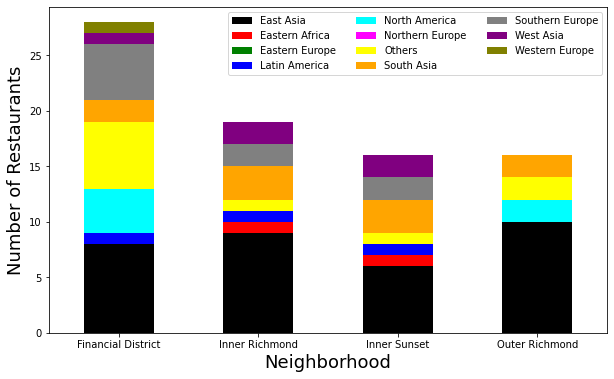

In [126]:
color_list = ['Black','red','green','blue','cyan','magenta','yellow','orange','grey','purple','olive']
ax0 = SF_group0.plot.bar(x='Neighborhood',rot=0, stacked=True, figsize=(10,6), color=color_list)
ax0.set_xlabel("Neighborhood", size=18)
ax0.set_ylabel("Number of Restaurants", size=18)
ax0.legend(loc='upper right', ncol=3)

From this bar graph, we can see that group0 is the neighborhoods where Eastern Asian restaurants are the most popular and Southern Asians are the second.

Likewise, let's look at other categories as well.

In [130]:
SF_group1 = SF_food_groupedbyRegion[SF_food_groupedbyRegion['Cluster Labels']==1]
SF_group1.head()

,Neighborhood,Cluster Labels,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe
3,Diamond Heights,1,2,0,0,0,0,0,0,0,0,0,0
7,Glen Park,1,2,0,0,1,0,0,0,1,1,0,0
8,Haight Ashbury,1,2,0,0,0,2,0,1,5,1,0,0
11,Lakeshore,1,2,0,0,1,1,0,0,0,0,0,0
13,Nob Hill,1,0,0,0,0,2,0,1,1,5,0,2


To understand the data better, let's plot with a bar graph

In [131]:
SF_group1 = SF_group1.drop('Cluster Labels',1)

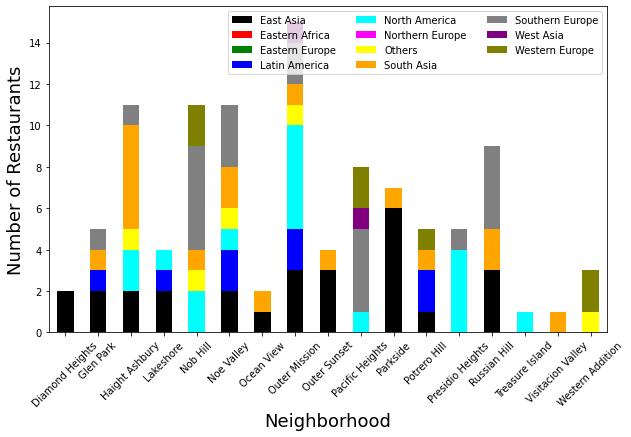

In [136]:
color_list = ['Black','red','green','blue','cyan','magenta','yellow','orange','grey','purple','olive']
ax1 = SF_group1.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax1.set_xlabel("Neighborhood", size=18)
ax1.set_ylabel("Number of Restaurants", size=18)
ax1.set_xticklabels(SF_group1['Neighborhood'],rotation=45)
ax1.legend(loc='upper right', ncol=3)

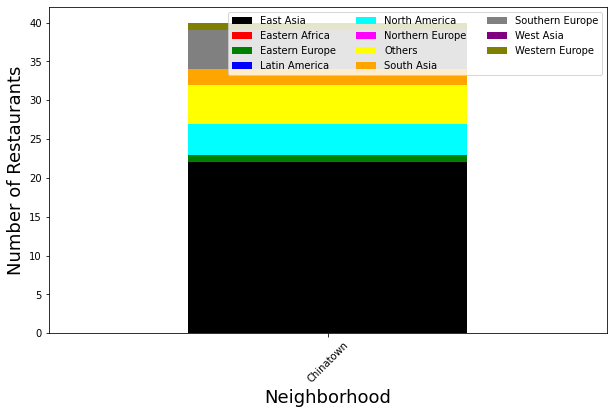

In [139]:
SF_group2 = SF_food_groupedbyRegion[SF_food_groupedbyRegion['Cluster Labels']==2]
SF_group2 = SF_group2.drop('Cluster Labels',1)
ax2 = SF_group2.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax2.set_xlabel("Neighborhood", size=18)
ax2.set_ylabel("Number of Restaurants", size=18)
ax2.set_xticklabels(SF_group2['Neighborhood'],rotation=45)
ax2.legend(loc='upper right', ncol=3)

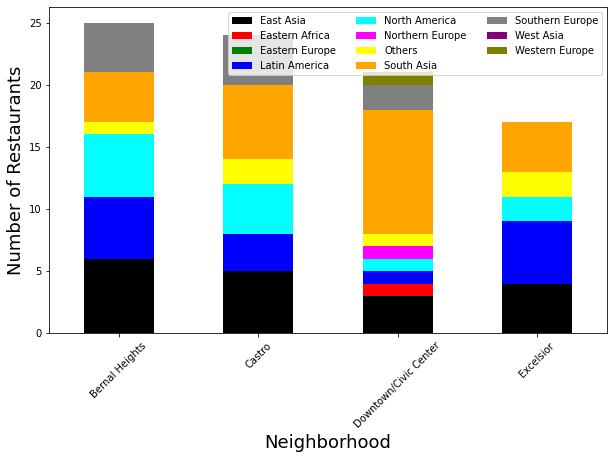

In [142]:
SF_group3 = SF_food_groupedbyRegion[SF_food_groupedbyRegion['Cluster Labels']==3]
SF_group3 = SF_group3.drop('Cluster Labels',1)
ax3 = SF_group3.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax3.set_xlabel("Neighborhood", size=18)
ax3.set_ylabel("Number of Restaurants", size=18)
ax3.set_xticklabels(SF_group3['Neighborhood'],rotation=45)
ax3.legend(loc='upper right', ncol=3)

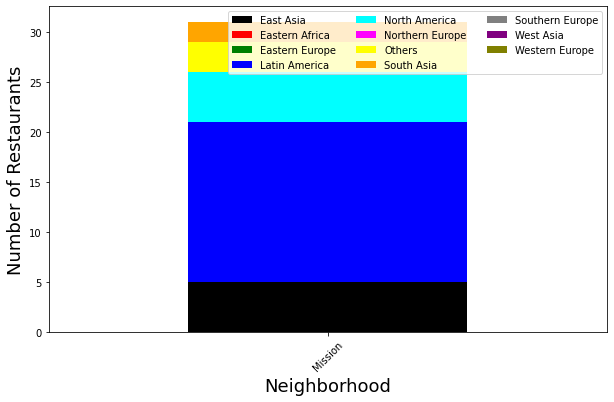

In [143]:
SF_group4 = SF_food_groupedbyRegion[SF_food_groupedbyRegion['Cluster Labels']==4]
SF_group4 = SF_group4.drop('Cluster Labels',1)
ax4 = SF_group4.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax4.set_xlabel("Neighborhood", size=18)
ax4.set_ylabel("Number of Restaurants", size=18)
ax4.set_xticklabels(SF_group4['Neighborhood'],rotation=45)
ax4.legend(loc='upper right', ncol=3)

There are only one neighborhood in group2 and group4. To view which neighborhodds are in which categories, I will use folium map.

Combine the locataion data and the labels by merging SF_data, which has latitude & longtidue of the neighborhood, and the labels.

In [165]:
SF_loclabels = SF_food_groupedbyRegion.merge(SF_data, on='Neighborhood',how='inner')
SF_loclabels.head()

,Neighborhood,Cluster Labels,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe,Latitude,Longitude
0,Bernal Heights,3,6,0,0,5,5,0,1,4,4,0,0,37.742986,-122.415804
1,Castro,3,5,0,0,3,4,0,2,6,4,0,0,37.760856,-122.434957
2,Chinatown,2,22,0,1,0,4,0,5,2,5,0,1,37.794301,-122.406376
3,Diamond Heights,1,2,0,0,0,0,0,0,0,0,0,0,37.746155,-122.441276
4,Downtown/Civic Center,3,3,1,0,1,1,1,1,10,2,0,1,37.783880,-122.412192


Let's visualize each grouop by color. 
- group0 : black
- group1 : red
- group2 : blue
- group3 : green
- group4 : cyan

In [167]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 12)

color = ['black', 'red', 'blue', 'green', 'cyan']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SF_loclabels['Latitude'], SF_loclabels['Longitude'], SF_loclabels['Neighborhood'], SF_loclabels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = color[cluster],
        fill = True,
        fill_color = color[cluster],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

From this map, it is easy to tell group0 has the most neighborhoods which have Eastern and Southern Asian foods. 

## Now let's repeat the same analysis for Los Angeles area.

In [179]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location_LA = geolocator.geocode(address)
latitude_LA = location_LA.latitude
longitude_LA = location_LA.longitude
print(latitude_LA, longitude_LA)

34.0536909 -118.242766


In [189]:
def latlngLA(neighborhood):
    address = neighborhood+', Los Angeles, CA'
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    return [latitude, longitude]

Since there are too many districts in LA city, I will load the list from an excel file, based on the website (http://www.laalmanac.com/cities/ci93.php)

In [190]:
LA_neigh_list = pd.read_excel('LA_Neighborhood_list.xlsx')
neigh_LA = LA_neigh_list['Neighborhood'].tolist()

LA_data = pd.DataFrame(columns=['Neighborhood', 'Latitude', 'Longitude'])

for i in range(0, len(neigh_LA)):
    try:
        loc = latlngLA(neigh_LA[i])
        LA_data=LA_data.append({'Neighborhood':neigh_LA[i], 'Latitude':loc[0], 'Longitude':loc[1]},
                               ignore_index=True)
    except:
        pass
LA_data

,Neighborhood,Latitude,Longitude
0,Del Rey,33.989653,-118.424344
1,Mar Vista,34.003760,-118.439164
2,Playa Del Rey,33.954145,-118.438807
3,Playa Vista,33.976010,-118.418165
4,Venice,33.988335,-118.461527
...,...,...,...
111,Rancho Park,34.034173,-118.426206
112,South Carthay,34.056121,-118.373411
113,Topanga State Park,34.086402,-118.559541
114,West Los Angeles,34.046399,-118.448135


In [194]:
LA_venues = getNearbyVenues(names=LA_data['Neighborhood'], latitudes=LA_data['Latitude'], longitudes=LA_data['Longitude'])
LA_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Del Rey,33.989653,-118.424344,Angel Maid Bakery,33.992295,-118.422227,Bakery
1,Del Rey,33.989653,-118.424344,Sakura Japanese Restaurant,33.991991,-118.422342,Sushi Restaurant
2,Del Rey,33.989653,-118.424344,LA Vegan,33.992738,-118.423236,Vegetarian / Vegan Restaurant
3,Del Rey,33.989653,-118.424344,Sachi.LA,33.991616,-118.421505,Coffee Shop
4,Del Rey,33.989653,-118.424344,Pepe's Tacos,33.991652,-118.421184,Taco Place
...,...,...,...,...,...,...,...
2312,West Los Angeles,34.046399,-118.448135,Santa Monica Glatt Kosher Market,34.045049,-118.452544,Grocery Store
2313,West Los Angeles,34.046399,-118.448135,Javan Restaurant,34.045220,-118.451970,Mediterranean Restaurant
2314,Westwood,34.056121,-118.430635,Café Chez Marie,34.053059,-118.430989,Coffee Shop
2315,Westwood,34.056121,-118.430635,Carmine's II,34.056356,-118.426159,Italian Restaurant


Leave only venues that contain 'Restaurants' in the category.

In [195]:
LA_food = LA_venues[LA_venues['Venue Category'].str.contains('Restaurant')]
LA_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Del Rey,33.989653,-118.424344,Sakura Japanese Restaurant,33.991991,-118.422342,Sushi Restaurant
2,Del Rey,33.989653,-118.424344,LA Vegan,33.992738,-118.423236,Vegetarian / Vegan Restaurant
6,Del Rey,33.989653,-118.424344,Casa Sanchez,33.992626,-118.422785,Mexican Restaurant
7,Del Rey,33.989653,-118.424344,Coni'seafood,33.992429,-118.422370,Mexican Restaurant
11,Del Rey,33.989653,-118.424344,Taqueria Sanchez,33.992069,-118.422490,Mexican Restaurant


In [196]:
LAvenues_map = folium.Map(location=[latitude_LA, longitude_LA], zoom_start=12)

marker_cluster = MarkerCluster().add_to(LAvenues_map)

for lat, lng, label in zip(LA_food['Neighborhood Latitude'], LA_food['Neighborhood Longitude'], LA_food['Venue Category']):
    folium.CircleMarker(
            [lat, lng],
            radius=2,
            color='blue',
            popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.2
        ).add_to(marker_cluster)
    
LAvenues_map

In [197]:
LA_food['Venue Category'].unique()

array(['Sushi Restaurant', 'Vegetarian / Vegan Restaurant',
       'Mexican Restaurant', 'Thai Restaurant', 'Indian Restaurant',
       'Mediterranean Restaurant', 'American Restaurant',
       'New American Restaurant', 'Hawaiian Restaurant',
       'Dumpling Restaurant', 'French Restaurant', 'Restaurant',
       'Ethiopian Restaurant', 'Latin American Restaurant',
       'Korean Restaurant', 'Japanese Restaurant', 'Fast Food Restaurant',
       'Asian Restaurant', 'Italian Restaurant', 'Seafood Restaurant',
       'Cantonese Restaurant', 'Middle Eastern Restaurant',
       'Falafel Restaurant', 'German Restaurant', 'Korean BBQ Restaurant',
       'Brazilian Restaurant', 'Ramen Restaurant',
       'Vietnamese Restaurant', 'Chinese Restaurant', 'Greek Restaurant',
       'South American Restaurant', 'Cuban Restaurant',
       'Spanish Restaurant', 'Kosher Restaurant',
       'Comfort Food Restaurant', 'Moroccan Restaurant',
       'Dongbei Restaurant', 'Cajun / Creole Restaurant',
    

I re-assigned the categories if they are too specific, as in the SF_food.

In [200]:
pd.options.mode.chained_assignment = None

LA_food.loc[(LA_food['Venue Category']=='Sushi Restaurant'), 'Venue Category'] ='Japanese Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Ramen Restaurant'), 'Venue Category'] ='Japanese Restaurant'

LA_food.loc[(LA_food['Venue Category']=='Hawaiian Restaurant'), 'Venue Category'] ='American Restaurant'
LA_food.loc[(LA_food['Venue Category']=='New American Restaurant'), 'Venue Category'] ='American Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Cajun / Creole Restaurant'), 'Venue Category'] ='American Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Tex-Mex Restaurant'), 'Venue Category'] ='American Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Southern / Soul Food Restaurant'), 'Venue Category'] ='American Restaurant'

LA_food.loc[(LA_food['Venue Category']=='Dumpling Restaurant'), 'Venue Category'] ='Chinese Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Dongbei Restaurant'), 'Venue Category'] ='Chinese Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Szechuan Restaurant'), 'Venue Category'] ='Chinese Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Cantonese Restaurant'), 'Venue Category'] ='Chinese Restaurant'

LA_food.loc[(LA_food['Venue Category']=='Falafel Restaurant'), 'Venue Category'] ='Middle Eastern Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Halal Restaurant'), 'Venue Category'] ='Middle Eastern Restaurant'

LA_food.loc[(LA_food['Venue Category']=='Korean BBQ Restaurant'), 'Venue Category'] ='Korean Restaurant'

LA_food.loc[(LA_food['Venue Category']=='South American Restaurant'), 'Venue Category'] ='Latin American Restaurant'

LA_food.loc[(LA_food['Venue Category']=='North Indian Restaurant'), 'Venue Category'] ='Indian Restaurant'
LA_food.loc[(LA_food['Venue Category']=='Andhra Restaurant'), 'Venue Category'] ='Indian Restaurant'

LA_food['Venue Category'].unique()

array(['Japanese Restaurant', 'Vegetarian / Vegan Restaurant',
       'Mexican Restaurant', 'Thai Restaurant', 'Indian Restaurant',
       'Mediterranean Restaurant', 'American Restaurant',
       'Chinese Restaurant', 'French Restaurant', 'Restaurant',
       'Ethiopian Restaurant', 'Latin American Restaurant',
       'Korean Restaurant', 'Fast Food Restaurant', 'Asian Restaurant',
       'Italian Restaurant', 'Seafood Restaurant',
       'Middle Eastern Restaurant', 'German Restaurant',
       'Brazilian Restaurant', 'Vietnamese Restaurant',
       'Greek Restaurant', 'Cuban Restaurant', 'Spanish Restaurant',
       'Kosher Restaurant', 'Comfort Food Restaurant',
       'Moroccan Restaurant', 'Filipino Restaurant',
       'Argentinian Restaurant', 'Eastern European Restaurant',
       'Caribbean Restaurant', 'English Restaurant',
       'Indonesian Restaurant'], dtype=object)

Next, using the same criteria, I assigned 'Region' to help the analysis.

In [204]:
LA_food['Region'] = LA_food['Venue Category'].apply(lambda row: assign_region(row))

LA_food

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Region
1,Del Rey,33.989653,-118.424344,Sakura Japanese Restaurant,33.991991,-118.422342,Japanese Restaurant,East Asia
2,Del Rey,33.989653,-118.424344,LA Vegan,33.992738,-118.423236,Vegetarian / Vegan Restaurant,Others
6,Del Rey,33.989653,-118.424344,Casa Sanchez,33.992626,-118.422785,Mexican Restaurant,Latin America
7,Del Rey,33.989653,-118.424344,Coni'seafood,33.992429,-118.422370,Mexican Restaurant,Latin America
11,Del Rey,33.989653,-118.424344,Taqueria Sanchez,33.992069,-118.422490,Mexican Restaurant,Latin America
...,...,...,...,...,...,...,...,...
2307,West Los Angeles,34.046399,-118.448135,Moon House Chinese Cuisine,34.047655,-118.443202,Chinese Restaurant,East Asia
2308,West Los Angeles,34.046399,-118.448135,Benito's Taco Shop,34.045768,-118.451494,Mexican Restaurant,Latin America
2313,West Los Angeles,34.046399,-118.448135,Javan Restaurant,34.045220,-118.451970,Mediterranean Restaurant,Southern Europe
2315,Westwood,34.056121,-118.430635,Carmine's II,34.056356,-118.426159,Italian Restaurant,Southern Europe


In [205]:
LA_food_count = pd.get_dummies(LA_food[['Region']], prefix="", prefix_sep="")
LA_food_count['Neighborhood'] = LA_food['Neighborhood']

fixed_columns = [LA_food_count.columns[-1]] + list(LA_food_count.columns[:-1])
LA_food_count = LA_food_count[fixed_columns]
LA_food_groupedbyRegion = LA_food_count.groupby('Neighborhood').sum().reset_index()

LA_food_groupedbyRegion.head()

,Neighborhood,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe
0,Arlington Heights,1,0,0,0,1,0,1,0,0,0,0
1,Atwater Village,1,0,0,2,2,0,2,0,2,1,0
2,Bel Air,0,0,0,0,0,0,1,0,0,0,0
3,Boyle Heights,4,0,0,8,0,0,8,0,0,0,0
4,Brentwood,0,0,0,0,0,0,0,0,2,0,0


## K-Means clustering

In [206]:
kclusters = 5
LA_cluster = LA_food_groupedbyRegion.drop('Neighborhood', 1)

kmeansLA = KMeans(n_clusters = kclusters, random_state = 0).fit(LA_cluster)
kmeansLA.labels_[0:10]

array([0, 3, 0, 4, 0, 3, 1, 4, 3, 2])

In [207]:
LA_food_groupedbyRegion.insert(1, 'Cluster Labels', kmeansLA.labels_)

LA_food_groupedbyRegion

,Neighborhood,Cluster Labels,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe
0,Arlington Heights,0,1,0,0,0,1,0,1,0,0,0,0
1,Atwater Village,3,1,0,0,2,2,0,2,0,2,1,0
2,Bel Air,0,0,0,0,0,0,0,1,0,0,0,0
3,Boyle Heights,4,4,0,0,8,0,0,8,0,0,0,0
4,Brentwood,0,0,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Wilshire Park,0,0,0,0,0,0,0,1,0,0,0,0
81,Wilshire Square,0,0,0,0,0,0,0,1,0,0,0,0
82,Wilshire Vista,0,0,0,0,2,0,0,0,0,1,0,0
83,Winnetka,0,0,0,0,1,0,0,2,0,0,1,0


In [221]:
LA_loclabels = LA_food_groupedbyRegion.merge(LA_data, on='Neighborhood',how='inner')
LA_loclabels = LA_loclabels.drop_duplicates()
LA_loclabels = LA_loclabels.reset_index(drop=True)
LA_loclabels.head()

,Neighborhood,Cluster Labels,East Asia,Eastern Africa,Eastern Europe,Latin America,North America,Northern Europe,Others,South Asia,Southern Europe,West Asia,Western Europe,Latitude,Longitude
0,Arlington Heights,0,1,0,0,0,1,0,1,0,0,0,0,34.043494,-118.321374
1,Atwater Village,3,1,0,0,2,2,0,2,0,2,1,0,34.116398,-118.256464
2,Bel Air,0,0,0,0,0,0,0,1,0,0,0,0,34.082728,-118.447980
3,Boyle Heights,4,4,0,0,8,0,0,8,0,0,0,0,34.043689,-118.209768
4,Brentwood,0,0,0,0,0,0,0,0,0,2,0,0,34.052140,-118.474070


In [223]:
map_clustersLA = folium.Map(location = [latitude_LA, longitude_LA], zoom_start = 12)

color = ['black', 'red', 'blue', 'green', 'cyan']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_loclabels['Latitude'], LA_loclabels['Longitude'], LA_loclabels['Neighborhood'], LA_loclabels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = color[cluster],
        fill = True,
        fill_color = color[cluster],
        fill_opacity = 0.7).add_to(map_clustersLA)
       
map_clustersLA

There are a lot more neighborhoods in LA than in SF.
As in SF, group0 has the most neighborhoods. However, it does not mean they are the same -- group 0 could have different categories. I will compare these later in the analysis.

First, let's look at how each cluster in LA looks like.

In [229]:
LA_group0 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==0]
LA_group1 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==1]
LA_group2 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==2]
LA_group3 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==3]
LA_group4 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==4]

LA_group0 = LA_group0.drop('Cluster Labels',1)
LA_group1 = LA_group1.drop('Cluster Labels',1)
LA_group2 = LA_group2.drop('Cluster Labels',1)
LA_group3 = LA_group3.drop('Cluster Labels',1)
LA_group4 = LA_group4.drop('Cluster Labels',1)

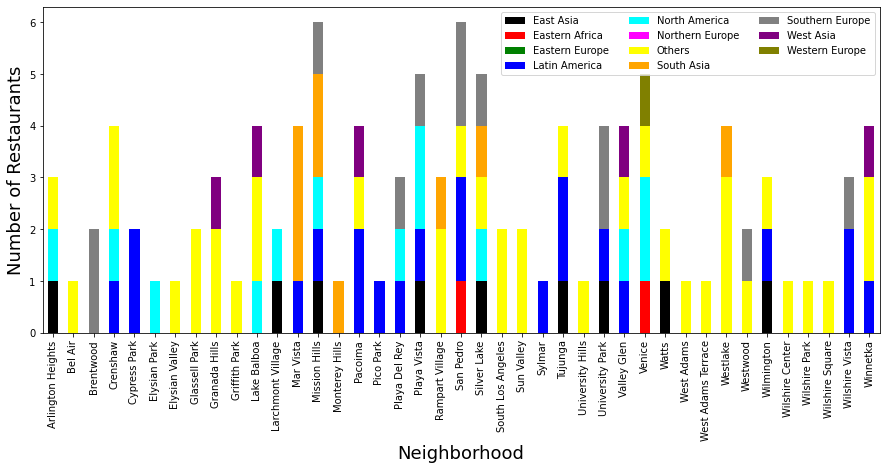

In [231]:
ax5 = LA_group0.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(15,6), color=color_list)
ax5.set_xlabel("Neighborhood", size=18)
ax5.set_ylabel("Number of Restaurants", size=18)
ax5.set_xticklabels(LA_group0['Neighborhood'],rotation=90)
ax5.legend(loc='upper right', ncol=3)

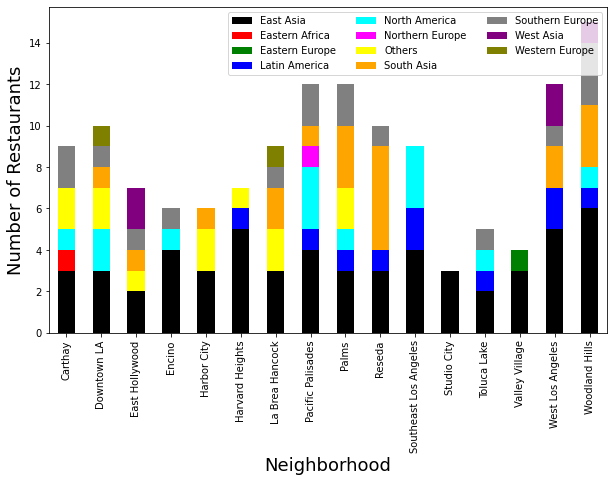

In [234]:
ax6 = LA_group1.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax6.set_xlabel("Neighborhood", size=18)
ax6.set_ylabel("Number of Restaurants", size=18)
ax6.set_xticklabels(LA_group1['Neighborhood'],rotation=90)
ax6.legend(loc='upper right', ncol=3)

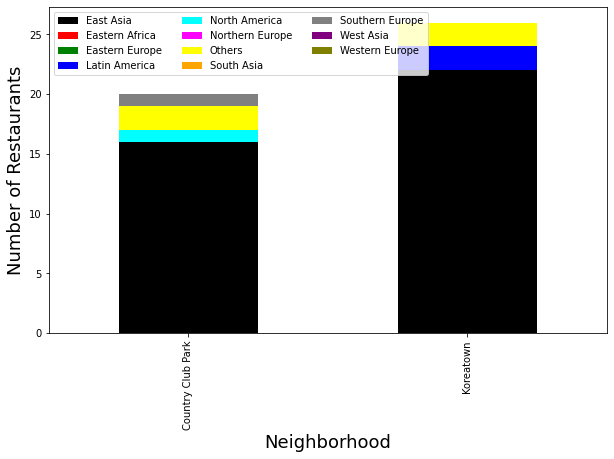

In [237]:
ax7 = LA_group2.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax7.set_xlabel("Neighborhood", size=18)
ax7.set_ylabel("Number of Restaurants", size=18)
ax7.set_xticklabels(LA_group2['Neighborhood'],rotation=90)
ax7.legend(loc='upper left', ncol=3)

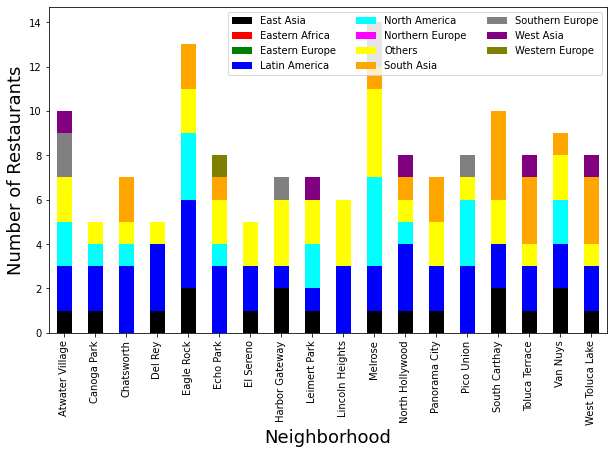

In [238]:
ax8 = LA_group3.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax8.set_xlabel("Neighborhood", size=18)
ax8.set_ylabel("Number of Restaurants", size=18)
ax8.set_xticklabels(LA_group3['Neighborhood'],rotation=90)
ax8.legend(loc='upper right', ncol=3)

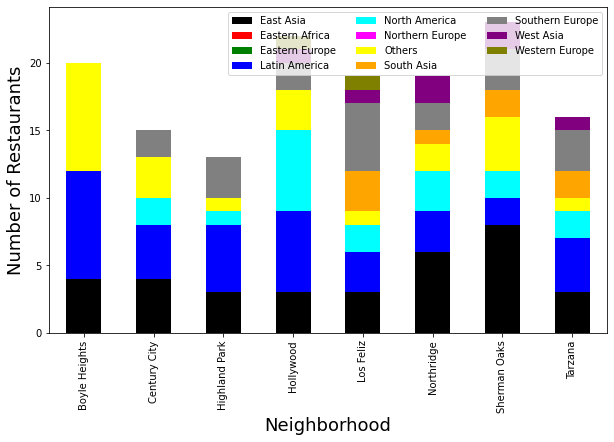

In [240]:
ax9 = LA_group4.plot.bar(x='Neighborhood', rot=0, stacked=True, figsize=(10,6), color=color_list)
ax9.set_xlabel("Neighborhood", size=18)
ax9.set_ylabel("Number of Restaurants", size=18)
ax9.set_xticklabels(LA_group4['Neighborhood'],rotation=90)
ax9.legend(loc='upper right', ncol=3)

In [241]:
LA_group0 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==0]
LA_group1 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==1]
LA_group2 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==2]
LA_group3 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==3]
LA_group4 = LA_food_groupedbyRegion[LA_food_groupedbyRegion['Cluster Labels']==4]

## Comparison between SF and LA

Here, I counted how many restaurants in each category in SF and LA area.
- 'LA_total' and 'SF_Total' are the sum of each category (region) in the entire LA and SF area, respectively.

In [320]:
Stat = LA_group0.sum().to_frame()
Stat.columns = ['LA_Cat0']
Stat['LA_Cat1'] = LA_group1.sum().to_frame()
Stat['LA_Cat2'] = LA_group2.sum().to_frame()
Stat['LA_Cat3'] = LA_group3.sum().to_frame()
Stat['LA_Cat4'] = LA_group4.sum().to_frame()
Stat['LA_Total'] = Stat['LA_Cat0']+Stat['LA_Cat1']+Stat['LA_Cat2']+Stat['LA_Cat3']+Stat['LA_Cat4']

Stat['SF_Cat0'] = SF_group0.sum().to_frame()
Stat['SF_Cat1'] = SF_group1.sum().to_frame()
Stat['SF_Cat2'] = SF_group2.sum().to_frame()
Stat['SF_Cat3'] = SF_group3.sum().to_frame()
Stat['SF_Cat4'] = SF_group4.sum().to_frame()
Stat['SF_Total'] = Stat['SF_Cat0']+Stat['SF_Cat1']+Stat['SF_Cat2']+Stat['SF_Cat3']+Stat['SF_Cat4']

Stat = Stat.drop(['Neighborhood', 'Cluster Labels'])

Stat = Stat.append(Stat.sum().rename('Total'))
Stat

,LA_Cat0,LA_Cat1,LA_Cat2,LA_Cat3,LA_Cat4,LA_Total,SF_Cat0,SF_Cat1,SF_Cat2,SF_Cat3,SF_Cat4,SF_Total
East Asia,9,56,38,18,34,155,33,27,22,18,5,105
Eastern Africa,2,1,0,0,0,3,2,0,0,1,0,3
Eastern Europe,0,1,0,0,0,1,0,0,1,0,0,1
Latin America,21,10,2,42,35,110,3,8,0,14,16,41
North America,13,13,1,20,18,65,6,17,4,12,5,44
Northern Europe,0,1,0,0,0,1,0,0,0,1,0,1
Others,38,12,4,33,23,110,10,5,5,6,3,29
South Asia,9,19,0,20,8,56,10,17,2,24,2,55
Southern Europe,12,16,1,6,20,55,9,21,5,10,0,45
West Asia,5,5,0,5,7,22,5,2,0,0,0,7


As can be seen, there are 584 restaurants in LA, while 341 in SF. Since LA has 1.7 times more restaurants than in SF, it is hard to compare the numbers directly to each other. For that, I used percentage. Each category is normalized to the total number of restaurants in each cluster. 

In [321]:
Stat_average = Stat/Stat.loc['Total']
Stat_average

,LA_Cat0,LA_Cat1,LA_Cat2,LA_Cat3,LA_Cat4,LA_Total,SF_Cat0,SF_Cat1,SF_Cat2,SF_Cat3,SF_Cat4,SF_Total
East Asia,0.081818,0.411765,0.826087,0.124138,0.231293,0.265411,0.417722,0.259615,0.55,0.206897,0.16129,0.307918
Eastern Africa,0.018182,0.007353,0.0,0.0,0.0,0.005137,0.025316,0.0,0.0,0.011494,0.0,0.008798
Eastern Europe,0.0,0.007353,0.0,0.0,0.0,0.001712,0.0,0.0,0.025,0.0,0.0,0.002933
Latin America,0.190909,0.073529,0.043478,0.289655,0.238095,0.188356,0.037975,0.076923,0.0,0.16092,0.516129,0.120235
North America,0.118182,0.095588,0.021739,0.137931,0.122449,0.111301,0.075949,0.163462,0.1,0.137931,0.16129,0.129032
Northern Europe,0.0,0.007353,0.0,0.0,0.0,0.001712,0.0,0.0,0.0,0.011494,0.0,0.002933
Others,0.345455,0.088235,0.086957,0.227586,0.156463,0.188356,0.126582,0.048077,0.125,0.068966,0.096774,0.085044
South Asia,0.081818,0.139706,0.0,0.137931,0.054422,0.09589,0.126582,0.163462,0.05,0.275862,0.064516,0.16129
Southern Europe,0.109091,0.117647,0.021739,0.041379,0.136054,0.094178,0.113924,0.201923,0.125,0.114943,0.0,0.131965
West Asia,0.045455,0.036765,0.0,0.034483,0.047619,0.037671,0.063291,0.019231,0.0,0.0,0.0,0.020528


Let's find top five popular venues in each cluster. 

In [309]:
def popular_venues(column):
    return Stat_average[column].sort_values(ascending=False).index.values[1:6]

In [322]:
Sorted = pd.DataFrame(popular_venues('LA_Cat0'), dtype="string", columns=['LA_Cat0'])
Sorted['LA_Cat1'] = popular_venues('LA_Cat1')
Sorted['LA_Cat2'] = popular_venues('LA_Cat2')
Sorted['LA_Cat3'] = popular_venues('LA_Cat3')
Sorted['LA_Cat4'] = popular_venues('LA_Cat4')
Sorted['LA_Total'] = popular_venues('LA_Total')

Sorted['SF_Cat0'] = popular_venues('SF_Cat0')
Sorted['SF_Cat1'] = popular_venues('SF_Cat1')
Sorted['SF_Cat2'] = popular_venues('SF_Cat2')
Sorted['SF_Cat3'] = popular_venues('SF_Cat3')
Sorted['SF_Cat4'] = popular_venues('SF_Cat4')
Sorted['SF_Total'] = popular_venues('SF_Total')

Sorted

,LA_Cat0,LA_Cat1,LA_Cat2,LA_Cat3,LA_Cat4,LA_Total,SF_Cat0,SF_Cat1,SF_Cat2,SF_Cat3,SF_Cat4,SF_Total
0,Others,East Asia,East Asia,Latin America,Latin America,East Asia,East Asia,East Asia,East Asia,South Asia,Latin America,East Asia
1,Latin America,South Asia,Others,Others,East Asia,Latin America,Others,Southern Europe,Others,East Asia,East Asia,South Asia
2,North America,Southern Europe,Latin America,North America,Others,Others,South Asia,North America,Southern Europe,Latin America,North America,Southern Europe
3,Southern Europe,North America,North America,South Asia,Southern Europe,North America,Southern Europe,South Asia,North America,North America,Others,North America
4,East Asia,Others,Southern Europe,East Asia,North America,South Asia,North America,Latin America,South Asia,Southern Europe,South Asia,Latin America


## < Discussion >

In this study, I compared the categories of the restaurants in San Francisco and Los Angeles, which are very culurally-diverse cities in California. The categories of the foods and the regions tell us which cultural foods are the most popular and how diverse the cities are. This analysis would be helpful to tourists or residents who would like to explore new kinds of foods. It would also benefit people who would like to open thier business. For example, if the neighborhood has many Eastern Asian restaurants, it would be good to open a business related to Eastern Asian because people who visit there are likely to be interested in exploring more of the culture. 

Though this analysis gives us a good insight, it has a few points that we need to remember. 

First, I filtered the venue categories with the search criteria 'restaurants' to exclude coffee shops or bakeries. However, there could be some restaurants whose category does not have a word 'restaurant', such as 'Poke Place' in SF. Poke is a Japanese food, but its category is 'Poke Place'. Due to the large volume of the data, it was difficult to fix it by hand and it was only a few restaurants, compared to the total number of restaurants in each city. Therefore, this would be a minor problem, but something that we can keep in mind.

Second, there is 'Fast Food' category. This is included in 'others' region, since it is hard to define which region it belongs to. 'Others' region also includes 'Vegan restaurants' or 'Seafood restaurants'. These could have been categorized as American foods, but it was hard to know which foods they are selling. Extra attention would be needed when looking at 'Others' category.

In both cities, the most popular food is Eastern Asian food and Latin American foods are also very popular. This shows how diverse both cities are. In SF and LA, there are many people from Asia or Latin America. These food categories reflect it very well. 

## < Conclusion >

In LA, there are more Latin American foods in Cluster3, which is west of downtown LA. Eastern Asian foods are popular in downtown area where Korean town and Chinese town are, and near Hollywood area. Cluster0, the black dots in the map, are distributed evenly throughout the entire LA area. In Cluster0, 'Others' is the most popular category. As mentioned in the third limitation, this 'Others' category includes a lot of fast food restaurants. Therefore, it shows that it would not be difficult to find a fastfood place anywhere in LA.

In SF, the distribution is quite interesting. Eastern Asian foods are the most popular in three clusters, Cluster0-2. In the map, they are distributed evenly throughout the entire area. The second popular category is 'Others', which most likely includes fast food restaurants. Latin American food, as shown in Cluster3 in SF, is the most popular in Mission district in SF.

Overall, restaurants in LA and SF are very diverse in culture, as expected from population. Eastern Asian foods, Latin American, and North American foods are the most popular in the two cities. The difference is those cultural foods are more concentrated in certain neighborhoods in LA, while they are homogenously distributed in SF. 